In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [2]:
# création d'un tableau pour l'affichage des versions 
table_lib_version = PrettyTable()
table_lib_version.field_names = ["Library", "numpy", "pandas", "tensorflow"]
table_lib_version.add_row(["Version", np.__version__, pd.__version__, tf.__version__])

print(table_lib_version)

+---------+-------+--------+------------+
| Library | numpy | pandas | tensorflow |
+---------+-------+--------+------------+
| Version | 2.1.3 | 2.2.3  |   2.19.0   |
+---------+-------+--------+------------+


<div style="background-color: #C7F3A5; padding: 10px;">
L’objectif de ce projet est d’explorer l’utilisation des réseaux de neurones récurrents, et plus particulièrement des modèles LSTM (Long Short-Term Memory), pour prédire différentes variables climatiques à partir de données historiques.

Afin d’évaluer l’efficacité des modèles LSTM dans ce contexte, trois approches ont été développées :

- Prédiction de la température uniquement à partir des températures des jours précédents, afin de tester l’influence des tendances passées sur la prévision.
- Prédiction de la température en prenant en compte plusieurs variables météorologiques (température, humidité, vitesse du vent et pression atmosphérique), dans le but d’étudier l’impact de ces facteurs sur la précision des prédictions.
- Prédiction de chaque variable météorologique en fonction de l’ensemble des autres variables, pour analyser les interdépendances entre ces paramètres et évaluer si leur prise en compte améliore la précision des prévisions.

L’étude vise ainsi à identifier le modèle le plus performant pour la prévision météorologique et à comprendre les limites des LSTM face à la complexité des phénomènes climatiques. Les résultats obtenus permettront d’évaluer si ces modèles sont adaptés à la modélisation des tendances météorologiques et quelles améliorations peuvent être apportées pour affiner leurs performances.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
The objective of this project is to explore the use of recurrent neural networks, particularly LSTM (Long Short-Term Memory) models, to predict various climate variables based on historical data.

To evaluate the effectiveness of LSTM models in this context, three approaches have been developed:

- Predicting temperature solely based on past temperature values, to assess the influence of historical trends on forecasting.
- Predicting temperature while considering multiple meteorological variables (temperature, humidity, wind speed, and atmospheric pressure) to study the impact of these factors on prediction accuracy.
- Predicting each meteorological variable based on all other variables, to analyze the interdependencies between these parameters and determine whether incorporating them improves forecast accuracy.

This study aims to identify the most effective model for weather forecasting and to understand the limitations of LSTMs in capturing the complexity of climatic phenomena. The results will help assess whether these models are suitable for modeling weather trends and what improvements can be made to enhance their performance.
</div>

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>I. Préparation des données </h1>
</div>

In [3]:
DailyClimateTrain = pd.read_csv("../Datasets/DailyClimateTrain.csv")
DailyClimateTest = pd.read_csv("../Datasets/DailyClimateTest.csv")

In [4]:
DailyClimateTrain.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
#index change
DailyClimateTrain.index = pd.to_datetime(DailyClimateTrain["date"], format="%Y-%m-%d")
climate_train = DailyClimateTrain.drop(columns=["date"])

DailyClimateTest.index = pd.to_datetime(DailyClimateTest["date"], format="%Y-%m-%d")
climate_test = DailyClimateTest.drop(columns=["date"])

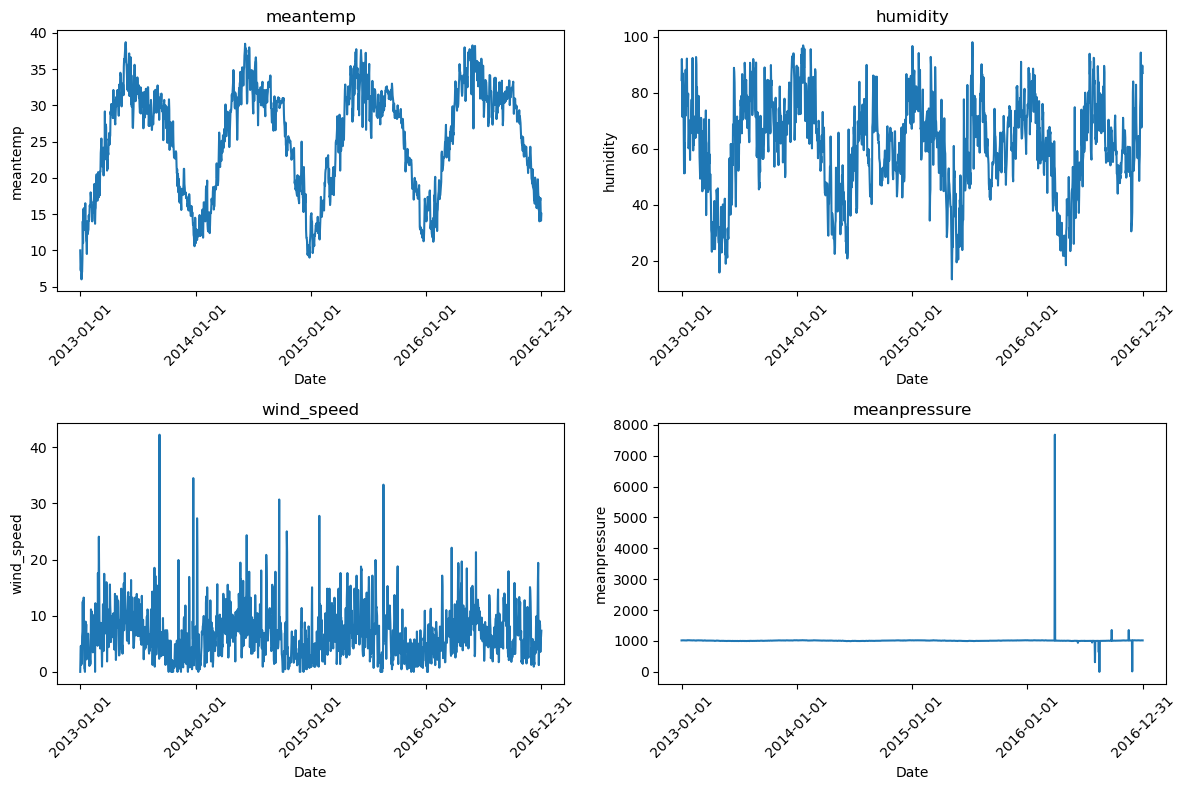

In [6]:
columns= ["meantemp", "humidity", "wind_speed", "meanpressure"]

plt.figure(figsize=(12, 8))

for idx, column in enumerate(columns, 1):
    plt.subplot(2, 2, idx)  # 2x2 grid for the subplots
    sns.lineplot(data=climate_train, x=climate_train.index, y=column)
    plt.title(f'{column}')
    plt.xlabel("Date")
    plt.ylabel(column)

    plt.xticks(
        climate_train.index[::365],  
        rotation=45, 
    )

plt.tight_layout()  
plt.show()

In [7]:
climate_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


<h3> Valeurs aberrantes </h3>

Le traitement des valeurs aberrantes est une étape essentielle dans l’analyse des données climatiques, car ces valeurs extrêmes peuvent fausser les prédictions des modèles et compromettre la fiabilité des résultats.

Commençons par une première analyse des distributions statistiques, nous allons utiliser des quartiles et de l’IQR (Interquartile Range) pour détecter les points anormalement éloignés.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

The treatment of outliers is a crucial step in climate data analysis, as these extreme values can distort model predictions and compromise the reliability of the results.

To begin with, we will conduct an initial analysis of statistical distributions by using quartiles and the Interquartile Range (IQR) to detect abnormally distant points.

In [8]:
Q1 = climate_train[columns].quantile(0.25)
Q3 = climate_train[columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((climate_train[columns] < (Q1 - 1.5 * IQR)) | (climate_train[columns] > (Q3 + 1.5 * IQR))).sum()

table_nb_outliers = PrettyTable()
table_nb_outliers.field_names = ["Variable", 
                                 "mean temp", 
                                 "humidity", 
                                 "wind speed", 
                                 "mean pressure"]

table_nb_outliers.add_row(["# Outliers", 
                           outliers["meantemp"],
                           outliers["humidity"],
                           outliers["wind_speed"],
                           outliers["meanpressure"]])

print(table_nb_outliers)

+------------+-----------+----------+------------+---------------+
|  Variable  | mean temp | humidity | wind speed | mean pressure |
+------------+-----------+----------+------------+---------------+
| # Outliers |     0     |    2     |     29     |       9       |
+------------+-----------+----------+------------+---------------+


On affiche les statistiques pour choisir les seuils afin de supprimer les Outliers.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We display the statistics to choose the thresholds in order to remove the outliers.

In [9]:
climate_train["wind_speed"].describe()

count    1461.000000
mean        6.806865
std         4.559688
min         0.000000
25%         3.475000
50%         6.250000
75%         9.250000
max        42.220000
Name: wind_speed, dtype: float64

In [10]:
climate_train["meanpressure"].describe()

count    1461.000000
mean     1011.101197
std       180.293335
min        -3.041667
25%      1001.571429
50%      1008.555556
75%      1014.937500
max      7679.333333
Name: meanpressure, dtype: float64

Le réglage des seuils sera basé à la fois sur les statistiques descriptives et les connaissances du domaine.
Les seuils doivent être raisonnables et réalistes en fonction de la nature des variables.
Nous remplacerons les valeurs aberrantes par la médiane afin de garantir que les données restent robustes, réduisant ainsi l'effet des valeurs extrêmes qui pourraient fausser les performances du modèle ou l'analyse.

Nous utiliserons les limites suivantes :

Nous admettons que: 
- La vitesse du vent ne peut pas être > 15 m/s ou < 0.
- La pression atmosphérique se situe entre 870 et 1080 atm.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

The setting of thresholds will be based on both descriptive statistics and domain knowledge.
The thresholds should be reasonable and realistic according to the nature of the variables.
We will be replacing outliers with the median to ensure the data remains robust, reducing the effect of extreme values that might distort model performance or analysis.

We will use the following bounds: 
- We admit that wind speed coudn't be > 15 m/s or < 0. 
- Atmospheric pressure lies between 870 and 1080 atm.

In [11]:
median_ws = climate_train.loc[climate_train["wind_speed"] < 15, "wind_speed"].median()
climate_train.loc[climate_train["wind_speed"] < 0, "wind_speed"] = 0
climate_train.loc[climate_train["wind_speed"] > 15, "wind_speed"] = np.nan
climate_train["wind_speed"] = climate_train["wind_speed"].fillna(median_ws)

climate_test.loc[climate_test["wind_speed"] < 0, "wind_speed"] = 0
climate_test.loc[climate_test["wind_speed"] > 15, "wind_speed"] = np.nan
climate_test["wind_speed"] = climate_test["wind_speed"].fillna(median_ws)


In [12]:
median_pres = climate_train.loc[(climate_train["meanpressure"] < 1080) & (climate_train["meanpressure"] > 870), "meanpressure"].median()
climate_train.loc[climate_train["meanpressure"] > 1080, "meanpressure"] = np.nan
climate_train.loc[climate_train["meanpressure"] < 870, "meanpressure"] = np.nan
climate_train["meanpressure"] = climate_train["meanpressure"].fillna(median_pres)

climate_test.loc[climate_test["meanpressure"] < 870, "meanpressure"] = np.nan
climate_test.loc[climate_test["meanpressure"] > 1080, "meanpressure"] = np.nan
climate_test["meanpressure"] = climate_test["meanpressure"].fillna(median_pres)


<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>II. Prédiction de la température grâce à la température </h1>
</div>

On normalise la température.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We scale the temperature.

In [13]:
temperature_scaler = MinMaxScaler()
scaled_temperature_train = temperature_scaler.fit_transform(climate_train[["meantemp"]])
scaled_temperature_test = temperature_scaler.transform(climate_test[["meantemp"]])

Nous créons des séquences de 30 jours de données de température afin de prédire la température du jour suivant (31ᵉ jour).
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We create sequences of 30 days of temperature data to predict the next day's (31st day's) temperature.

In [14]:
def create_sequences(data, sequence_length):
    """
    Génère des séquences de longueur donnée à partir d'une série temporelle.

    Paramètres :
    - data : np.array, série temporelle normalisée
    - sequence_length : int, nombre de timesteps à inclure dans chaque séquence

    Retourne :
    - sequences : np.array, tableau contenant les séquences générées
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length + 1]  # Séquence + valeur cible
        sequences.append(sequence)
    
    return np.array(sequences)

In [15]:
sequence_length = 30
train_sequences = create_sequences (scaled_temperature_train, sequence_length)
test_sequences = create_sequences (scaled_temperature_test, sequence_length)

Nous séparons l'entrée et la sortie, où l'entrée se compose des 30 valeurs de température précédentes, et la sortie est la température du 31ᵉ jour.
Nous reformons ensuite les données en un tableau 3D adapté à l'entrée d'un LSTM.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We separate the input and output, where the input consists of previous 30 temperature values, and the otput is the 31st day's temperature.
We then reshape the data into a 3D array suitable for LSTM input.

In [16]:
meantemp_train_sequence = train_sequences[:, :-1] 
meantemp_train_prediction = train_sequences[:, -1, 0] 

meantemp_test_sequence = test_sequences[:, :-1]  
meantemp_test_prediction = test_sequences[:, -1, 0] 

In [17]:
meantemp_train_sequence.shape ,meantemp_test_sequence.shape

((1431, 30, 1), (84, 30, 1))

Nous avons des matrices de forme (n_samples, n_timesteps, n_var), où n_samples est le nombre d'exemples, n_timesteps est la longueur de chaque séquence (30 jours) et n_var est le nombre de variable par timestep (une seule - la température).

La structure attendue par un modèle LSTM nécessite la forme (n_samples, 1, n_timesteps) pour que chaque échantillon contienne la séquence complète de 30 jours avec 1 feature par timestep.

Nous allons donc structurer les données dans un format que les modèles LSTM peuvent comprendre et utiliser efficacement.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We have matrices in the shape of (n_samples, n_timesteps, n_var), where n_samples is the number of examples, n_timesteps is the length of each sequence (30 days), and n_var is the number of variables per timestep (only one – temperature).

The structure expected by an LSTM model requires the shape (n_samples, 1, n_timesteps) so that each sample contains the full 30-day sequence with one feature per timestep.

We will therefore structure the data in a format that LSTM models can understand and use efficiently.

In [18]:
meantemp_train_sequence = meantemp_train_sequence.reshape(-1, 1, sequence_length)
meantemp_test_sequence = meantemp_test_sequence.reshape(-1, 1, sequence_length)

In [19]:
meantemp_train_sequence.shape ,meantemp_test_sequence.shape

((1431, 1, 30), (84, 1, 30))

#### LSTM Model

On crée un modele LSTM qui prend en entrée une variable, la température, et nous donne en sortie la température prédite.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We create a LSTM model that takes one variable, temperature, as input and gives the predicted temperature as output. 

In [20]:
model_1 = Sequential()
model_1.add(Input(shape=(1, 30))) 
model_1.add(LSTM(100, return_sequences=True))
model_1.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_1.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_1.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model_1.add(Dense(1, activation="linear"))

model_1.compile(optimizer="adam", loss="mean_squared_error")

model_1.fit(meantemp_train_sequence, meantemp_train_prediction, batch_size=32, epochs=50)


2025-03-25 16:21:09.864600: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-25 16:21:09.864631: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-25 16:21:09.864638: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1742916069.865021 2382575 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742916069.865198 2382575 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-03-25 16:21:11.111801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.2853
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0117
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0081
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0065
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0054
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0048
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0040
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0038
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0040
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0038
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0036
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0035
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0035
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0036
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0032
Epoch 16/50
45/

On prédit les températures à partir des séquences de test, puis on applique inverse_transform pour ramener les valeurs prédites et réelles à leur échelle d'origine. Enfin, on redimensionne les valeurs réelles du test pour les adapter à l'échelle nécessaire avant de les inverser également.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We predict the temperatures from the test sequences, then apply inverse_transform to bring the predicted and actual values back to their original scale. Finally, we reshape the actual test values to fit the required scale before also inverting them.

In [21]:
predictions_test = model_1.predict(meantemp_test_sequence)
predictions_test = temperature_scaler.inverse_transform(predictions_test)

meantemp_test_prediction = meantemp_test_prediction.reshape(-1,1)
meantemp_test_prediction = temperature_scaler.inverse_transform(meantemp_test_prediction)

predictions_test.shape, meantemp_test_prediction.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


((84, 1), (84, 1))

On trace les températures réelles et prédites au fil du temps.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We plot the actual and predicted temperatures over time.

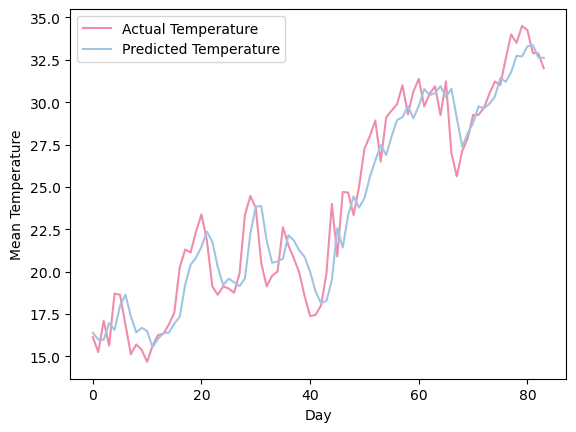

In [22]:
plt.plot(meantemp_test_prediction, label="Actual Temperature", color="#F08CAE")
plt.plot(predictions_test, label="Predicted Temperature", color="#A0C4E2")
plt.legend(loc="best")
plt.xlabel("Day")
plt.ylabel("Mean Temperature")
plt.show()

 On évalue la qualité des prédictions du modèle en comparant les valeurs réelles aux valeurs prédites
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
 We evaluate the quality of the model's predictions by comparing the actual values to the predicted values.

In [23]:
score_model_1=r2_score(meantemp_test_prediction, predictions_test)
score_model_1

0.9187812403057605

En conclusion, le modèle présente une performance remarquable avec un R² de 91 %, indiquant qu'il explique bien la variance des données réelles. De plus, les graphiques des températures réelles et prédites se superposent presque entièrement, ce qui démontre la précision élevée des prédictions du modèle.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

In conclusion, the model performs remarkably well with an R² of 91%, indicating it explains most of the variance in the actual data. Additionally, the graphs of actual and predicted temperatures almost overlap, demonstrating the high accuracy of the model's predictions.

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>II. Prédiction de la température à l'aide de plusieurs paramètres  </h1>
</div>

On procède comme avant, sauf que l'on crée notre jeu d'entrainement à partir de ces 4 variables que l'on normalise auparavant. Cependant la valeur à prédire reste la même.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We proceed as before, except that we create our training set using these four variables, which we scale beforehand. However, the value to be predicted remains the same.

In [24]:
scaled_train = temperature_scaler.fit_transform(climate_train)
scaled_test = temperature_scaler.fit_transform(climate_test)

In [25]:
train_sequences_2 = create_sequences(scaled_train, sequence_length)
test_sequences_2 = create_sequences(scaled_test, sequence_length)

In [26]:
meantemp_4vars_train_sequence = train_sequences_2[:, :-1] 
meantemp_4vars_train_prediction = train_sequences_2[:, -1, 0] 

meantemp_4vars_test_sequence = test_sequences_2[:, :-1] 
meantemp_4vars_test_prediction = test_sequences_2[:, -1, 0] 

In [27]:
meantemp_4vars_train_sequence.shape , meantemp_4vars_train_prediction.shape

((1431, 30, 4), (1431,))

In [28]:
meantemp_4vars_test_sequence.shape , meantemp_4vars_test_prediction.shape

((84, 30, 4), (84,))

In [29]:
meantemp_4vars_train_sequence = meantemp_4vars_train_sequence.reshape(-1, 4, 30)
meantemp_4vars_test_sequence = meantemp_4vars_test_sequence.reshape(-1, 4, 30)

In [30]:
meantemp_4vars_train_sequence.shape, meantemp_4vars_test_sequence.shape

((1431, 4, 30), (84, 4, 30))

#### LSTM model 

In [31]:
model_2=Sequential()
model_2.add(Input(shape=(4, 30))) 
model_2.add(LSTM(100, return_sequences=True))
model_2.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_2.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_2.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model_2.add(Dense(1, activation='linear'))

model_2.compile(optimizer='adam', loss='mean_squared_error')

model_2.fit(meantemp_4vars_train_sequence, meantemp_4vars_train_prediction, batch_size=32, epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - loss: 0.1538
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0109
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - loss: 0.0088
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0081
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0082
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 0.0091
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0075
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0070
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0059
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.0062
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0054
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - loss: 0.0049
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - loss: 0.0060
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step - loss: 0.0050
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254m

On effectue des prédictions avec model_2, puis on répète les valeurs pour correspondre au format attendu par l'inverse de la normalisation. Enfin, après la dénormalisation on récupère seulement la premiere colonne qui correspond à nos prédictions. 
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We make predictions with model_2, then repeat the values to match the format expected by the inverse normalization. Finally, after denormalization, we extract only the first column, which corresponds to our predictions.

In [32]:
predictions_test_2 = model_2.predict(meantemp_4vars_test_sequence)
predictions_test_2 = np.repeat(predictions_test_2, 4, axis=-1)
predictions_test_2 = temperature_scaler.inverse_transform(predictions_test_2)
predictions_test_2 = predictions_test_2[:,0]
predictions_test_2.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


(84,)

On procède de même pour nos vraies valeurs.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
We proceed the same way for our true values.

In [33]:
meantemp_4vars_test_prediction = meantemp_4vars_test_prediction.reshape(-1,1)
meantemp_4vars_test_prediction = np.repeat(meantemp_4vars_test_prediction, 4, axis=-1)
meantemp_4vars_test_prediction = temperature_scaler.inverse_transform(meantemp_4vars_test_prediction)

In [34]:
meantemp_4vars_test_prediction = meantemp_4vars_test_prediction[:,0]

On trace les températures réelles et prédites au fil du temps.

<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

We plot the actual and predicted temperatures over time.

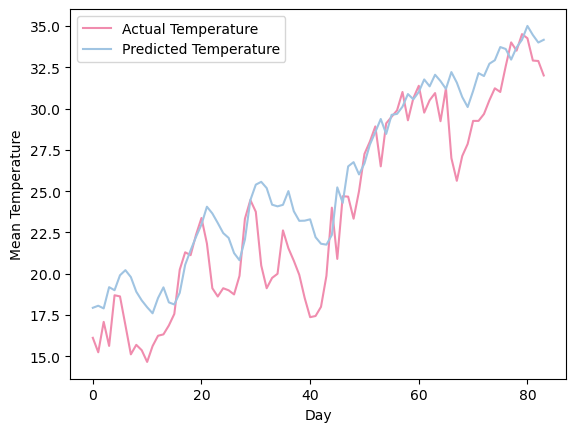

In [35]:
plt.plot(meantemp_4vars_test_prediction, label='Actual Temperature', color='#F08CAE')
plt.plot(predictions_test_2, label='Predicted Temperature', color='#A0C4E2')
plt.legend(loc='best')
plt.xlabel('Day')
plt.ylabel('Mean Temperature')
plt.show()

In [36]:
score_model_2 = r2_score(meantemp_4vars_test_prediction, predictions_test_2)
score_model_2

0.7923456535865632

Ce modèle LSTM, entraîné avec plusieurs paramètres (température, humidité, vitesse du vent et pression), a obtenu un score R² de 0,82 pour la prédiction de la température. Cela indique que le modèle capture une grande partie de la variabilité des données, fournissant des prédictions relativement précises. Cependant, les résultats du premier modèle montrent que la température seule contient suffisamment de motifs temporels pour une prévision précise, et qu'un modèle plus simple pourrait être plus efficace dans ce cas.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

This LSTM model, trained with multiple parameters (temperature, humidity, wind speed, and pressure), achieved an R² score of 0.82 for temperature prediction. This indicates that the model captures most of the variability in the data, making reasonably accurate predictions. However, the results of the first model indicate that temperature alone carries enough temporal patterns for accurate forecasting, and a simpler model may be more effective in this case.


<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>III. Prédiction de chaque variable à partir de tous les paramètres  </h1>
</div>

In [37]:
train_sequences_3 = create_sequences(scaled_train, sequence_length)
test_sequences_3 = create_sequences(scaled_test, sequence_length)

In [38]:
all_vars_train_sequence = train_sequences_2[:, :-1] 
all_vars_train_prediction = train_sequences_2[:, -1, 0:4] 

all_vars_test_sequence = test_sequences_2[:, :-1] 
all_vars_test_prediction = test_sequences_2[:, -1, 0:4] 

In [39]:
all_vars_train_sequence.shape, all_vars_train_prediction.shape

((1431, 30, 4), (1431, 4))

In [40]:
all_vars_test_sequence.shape, all_vars_test_prediction.shape

((84, 30, 4), (84, 4))

In [41]:
all_vars_train_sequence = all_vars_train_sequence.reshape(-1, 4, 30)
all_vars_test_sequence = all_vars_test_sequence.reshape(-1, 4, 30)

In [42]:
all_vars_train_sequence.shape, all_vars_test_sequence.shape

((1431, 4, 30), (84, 4, 30))

#### LSTM model

In [43]:
model_3=Sequential()
model_3.add(Input(shape=(4, 30))) 
model_3.add(LSTM(100, return_sequences=True))
model_3.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_3.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model_3.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model_3.add(Dense(4, activation='linear'))

model_3.compile(optimizer='adam', loss='mean_squared_error')

model_3.fit(all_vars_train_sequence, all_vars_train_prediction, batch_size=32, epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step - loss: 0.1920
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.0346
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 0.0241
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - loss: 0.0231
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0223
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0222
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0217
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.0217
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0205
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0192
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 0.0181
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0173
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0165
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.0160
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - l

#### Predictions

In [44]:
predictions_test_3 = model_3.predict(all_vars_test_sequence)
predictions_test_3 = temperature_scaler.inverse_transform(predictions_test_3)
predictions_test_3.shape

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3211b1870> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


(84, 4)

In [45]:
all_vars_test_prediction = temperature_scaler.inverse_transform(all_vars_test_prediction)
all_vars_test_prediction.shape

(84, 4)

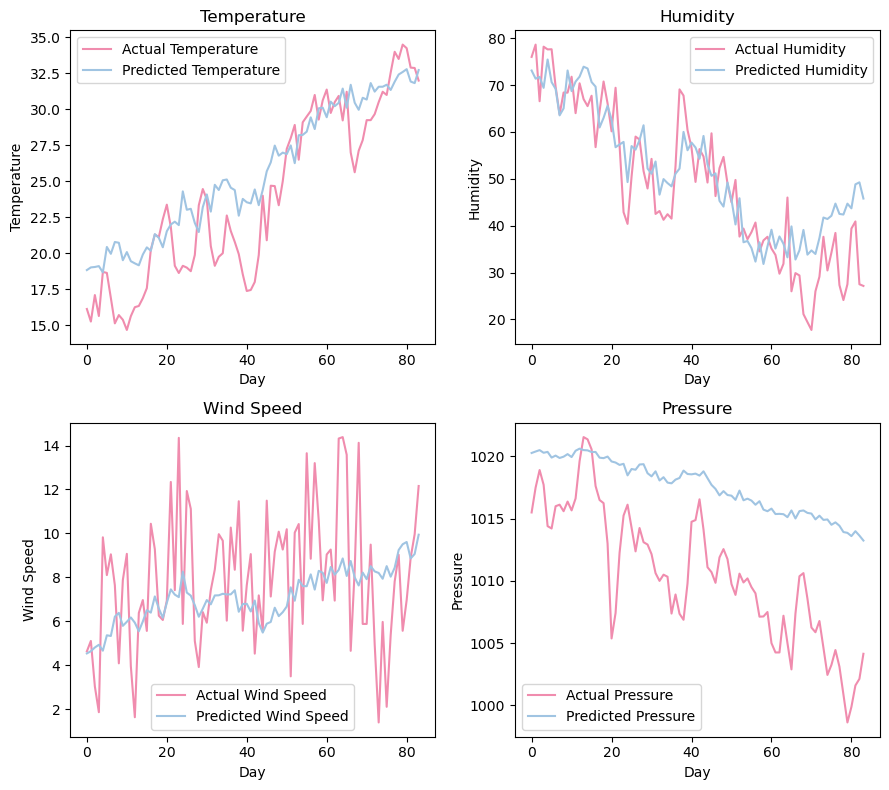

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8))  # 2x2 grid with reasonable size
variables = ["Temperature", "Humidity", "Wind Speed", "Pressure"]
colors = ["#F08CAE", "#A0C4E2"]  # Actual and Predicted colors

for i, (ax, col) in enumerate(zip(axes.flat, variables)):
    ax.plot(all_vars_test_prediction[:, i], label=f"Actual {col}", color=colors[0])
    ax.plot(predictions_test_3[:, i], label=f"Predicted {col}", color=colors[1])
    ax.legend(loc="best")
    ax.set_xlabel("Day")
    ax.set_ylabel(col)
    ax.set_title(col) 

plt.tight_layout()  
plt.show()

In [47]:
# R2
temperature_r2 = r2_score(all_vars_test_prediction[:, 0], predictions_test_3[:, 0])  
humidity_r2 = r2_score(all_vars_test_prediction[:, 1], predictions_test_3[:, 1])   
wind_speed_r2 = r2_score(all_vars_test_prediction[:, 2], predictions_test_3[:, 2])  
pressure_r2 = r2_score(all_vars_test_prediction[:, 3], predictions_test_3[:, 3])    

table_score = PrettyTable()
table_score.field_names = ["Variable", "R2 Score"]

table_score.add_row(["Temperature", round(temperature_r2,2)])
table_score.add_row(["Humidity", round(humidity_r2,2)])
table_score.add_row(["Wind Speed", round(wind_speed_r2,2)])
table_score.add_row(["Pressure", round(pressure_r2,2)])

print(table_score)


+-------------+----------+
|   Variable  | R2 Score |
+-------------+----------+
| Temperature |   0.74   |
|   Humidity  |   0.72   |
|  Wind Speed |  -0.04   |
|   Pressure  |  -1.24   |
+-------------+----------+


Le modèle entraîné sur tous les paramètres pour prédire chaque variable a donné des résultats modérément bons pour la température (R² = 0,78) mais a rencontré des difficultés significatives avec les autres variables. L'humidité (R² = 0,54) montre un certain pouvoir prédictif, bien que peu précis. Cependant, la vitesse du vent (R² = -0,06) et la pression (R² = -1,54) affichent des prédictions très médiocres, ce qui signifie que le modèle ne parvient pas à capturer efficacement leurs tendances.

D'après les graphiques, les prédictions de température et d'humidité suivent globalement les tendances réelles, mais avec des écarts notables. En revanche, les prédictions de la vitesse du vent et de la pression ne s'alignent pas correctement avec les valeurs réelles, confirmant leurs faibles scores R². Ces résultats suggèrent que le modèle n'est peut-être pas adapté à la prévision multi-variable.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

The model trained on all parameters to predict each variable performed moderately well for temperature (R² = 0.78) but struggled significantly with other variables. Humidity (R² = 0.54) shows some predictive power, though not highly accurate. However, wind speed (R² = -0.06) and pressure (R² = -1.54) indicate very poor predictions, meaning the model fails to capture their patterns effectively.

From the plots, temperature and humidity predictions follow the actual trends but with noticeable deviations. Wind speed and pressure predictions, however, fail to align properly with real values, confirming their low R² scores. These results suggest that the model may not be well-suited for multi-variable forecasting. 

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>IV. Conclusion </h1>
</div>

L'analyse des trois modèles appliqués aux données climatiques quotidiennes révèle des performances variables selon les paramètres prédits et la complexité des modèles. 

Les modèles LSTM fonctionnent le mieux sur des données présentant des tendances saisonnières ou temporelles marquées, comme la température et l'humidité, où leurs performances sont satisfaisantes (R² élevés). En revanche, pour des variables plus irrégulières ou bruyantes, telles que la vitesse du vent et la pression, les prédictions sont médiocres (R² négatifs ou proches de zéro), ce qui suggère que ces données nécessitent soit un prétraitement spécifique (normalisation, filtrage du bruit), soit des architectures de modèles plus adaptées. 

La distribution des données joue donc un rôle clé : plus les séries temporelles sont stables et périodiques, mieux les LSTM capturent leurs motifs. Pour des variables complexes ou faiblement corrélées, une approche alternative (modèles hybrides, features supplémentaires) pourrait être nécessaire.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">

Analysis of the three models applied to daily climate data reveals varying performance depending on the predicted parameters and model complexity.

LSTM models perform best on data with clear seasonal or temporal trends, such as temperature and humidity, where their performance is satisfactory (high R² scores). In contrast, for more irregular or noisy variables like wind speed and pressure, predictions are poor (negative or near-zero R²), suggesting that these datasets require either specific preprocessing (normalization, noise filtering) or more suitable model architectures.

Data distribution plays a key role: The more stable and periodic the time series, the better LSTMs capture their patterns. For complex or weakly correlated variables, an alternative approach (hybrid models, additional features) may be necessary.